In [17]:
import sys
sys.path.append('../')

import os
import json
import numpy as np

import torch
import models_vit
import rasterio
from rasterio.enums import Resampling
from util.fmow_datasets import build_fmow_dataset, SentinelIndividualImageDataset

import matplotlib.pyplot as plt
from PIL import Image
from collections import namedtuple

In [18]:
ArgObject = namedtuple('ArgObject', [
    'model', 'batch_size', 'input_size', 'nb_classes', 'train_path', 'test_path', 'dataset_type',
    'device', 'seed', 'resume', 'eval', 'num_workers'
])
args = ArgObject(
    model='vit_base_patch16',
    batch_size=16,
    input_size=224,
    train_path='/atlas/u/pliu1/housing_event_pred/data/fmow-sentinel-filtered-csv/train.csv',
    test_path='/atlas/u/pliu1/housing_event_pred/data/fmow-sentinel-filtered-csv/val.csv',
    dataset_type='sentinel',
    nb_classes=62,
    device='cuda',
    seed=0,
    resume='/atlas/u/samarkhanna/output_finetune_imgnet/checkpoint-9.pth',
    eval=True,
    num_workers=2
)

In [19]:
device = torch.device(args.device)

In [84]:
dataset_train = build_fmow_dataset(is_train=True, args=args)
dataset_val = build_fmow_dataset(is_train=False, args=args)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    drop_last=False
)

/nlp/scr/samarkhanna/miniconda3/envs/sat_env/lib/python3.7/site-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


/nlp/scr/samarkhanna/miniconda3/envs/sat_env/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [91]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def read_img(dataset, idx):
    selection = dataset.df.iloc[idx]
    with rasterio.open(selection['image_path']) as data:
        img = data.read(out_shape=(data.count, 224, 224), resampling=Resampling.bilinear)
    return img.transpose(1, 2, 0)

def read_label(idx):
    selection = dataset_val.df.iloc[idx]
    return selection['category']

def read_bands(idx, bands):
    bands = [b -1 for b in bands]
    img = read_img(dataset_val, idx)[:, :, bands]
    return normalize(img)

(224, 224)


/nlp/scr/samarkhanna/miniconda3/envs/sat_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


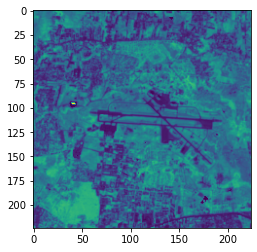

In [92]:
img = read_bands(3, [8, 4])
img =  (img[:, :, 0] - img[:, :, 1])/(img[:, :, 0] + img[:, :, 1])

print(img.shape)
im = Image.fromarray((img*255).astype(np.uint8))
plt.imshow(im)

In [93]:
len(dataset_val)

84939

In [90]:
base_dir = '../figures/sentinel'
os.makedirs('../figures/sentinel', exist_ok=True)

In [97]:
for i in range(10000,10101):
    img1 = read_bands(i, [4, 3, 2])  # Natural
    im1 = Image.fromarray((img1*255).astype(np.uint8))
    
    img2 = read_bands(i, [8, 4, 3])  # Infrared
    im2 = Image.fromarray((img2*255).astype(np.uint8))
    
    img3 = read_bands(i, [9, 12])  # Moisture
    img3 = (img3[:, :, 0] - img3[:, :, 1])/(img3[:, :, 0] + img3[:, :, 1])
    im3 = Image.fromarray((img3*255).astype(np.uint8))
    
    img4 = read_bands(i, [13, 9, 4])  # SWIR
    im4 = Image.fromarray((img4*255).astype(np.uint8))
    
    info = {
        'label': read_label(i)
    }
    
    with open(os.path.join(base_dir, f'{i}.json'), 'w') as f:
        json.dump(info, f)
    im1.save(os.path.join(base_dir, f'rgb_{i}.jpg'))
    im2.save(os.path.join(base_dir, f'infra_{i}.jpg'))
    im3.save(os.path.join(base_dir, f'moisture_{i}.jpg'))
    im4.save(os.path.join(base_dir, f'swir_{i}.jpg'))
    

/nlp/scr/samarkhanna/miniconda3/envs/sat_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
